In [59]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, f1_score, matthews_corrcoef
from skimage import io
import matplotlib.pyplot as plt
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.models import Sequential, Model,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.initializers import glorot_uniform
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D,Dropout
import keras_tuner as kt
#Suppressing Warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [60]:
path="animals/animals"
data = {"imgpath": [] , "labels": [] }

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)
      
print(data["labels"])
df = pd.DataFrame(data) 

#Convert labels to numbers
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])

['Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat', 'Cat'

## Model 1 Data Processing

In [61]:
train_df, test_df = train_test_split(df, test_size=0.3, shuffle=True, random_state=124)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                             imgpath    labels
0  animals/animals/Elephant/Elephant-Train (626)....  Elephant
1    animals/animals/Hippo/Hippo - Train (1313).jpeg     Hippo
2    animals/animals/Beetle/Beetle-Train (1453).jpeg    Beetle
3     animals/animals/Hippo/Hippo - Train (549).jpeg     Hippo
4            animals/animals/Panda/Panda (2791).jpeg     Panda
(14000, 3)
----------Test--------------
                                          imgpath  labels
0        animals/animals/Cow/Cow-Train (906).jpeg     Cow
1  animals/animals/Beetle/Beetle-Train (773).jpeg  Beetle
2   animals/animals/Mouse/Mouse-Train (1190).jpeg   Mouse
3  animals/animals/Beetle/Beetle-Train (707).jpeg  Beetle
4         animals/animals/Dog/Dog-Train (121).jpg     Dog
(6000, 3)


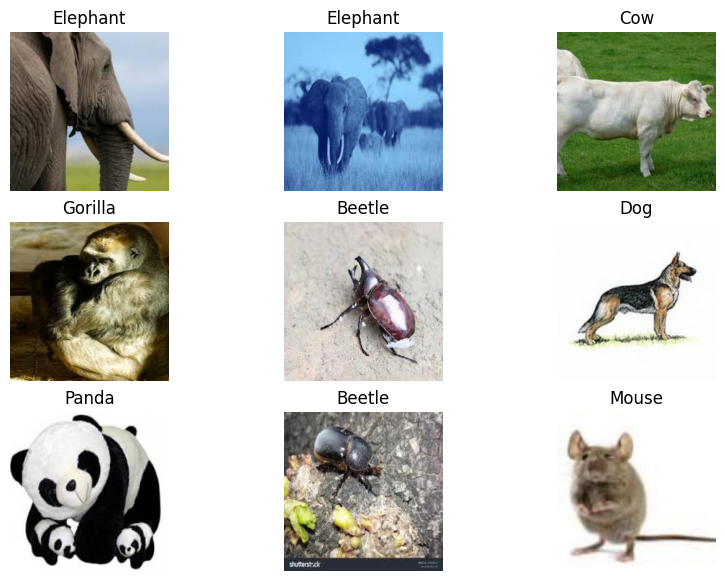

In [62]:
plt.figure(figsize=(10,7))
for i, row in test_df.sample(n=9).reset_index().iterrows():
    plt.subplot(3,3,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

In [63]:
h=100
w=100
classes = len(df['labels'].unique())
BATCH_SIZE = 16
IMAGE_SIZE = (h, w)

generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
)

# Split the data into 2 categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 14000 validated image filenames belonging to 10 classes.
Found 6000 validated image filenames belonging to 10 classes.


## Model 1

In [64]:
def residual_block(x, filters, kernel_size=3, stride=1, use_bottleneck=False):
    shortcut = x
    
    if use_bottleneck:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def ResNet(hp):
    input_shape = (h, w, 3)  # Adjust input shape according to your needs
    num_classes = classes
    input_tensor = layers.Input(shape=input_shape)
    hp_kernel_size = hp.Choice('kernel_size',[5,6,7])
    hp_dropout = hp.Choice('dropout',[0.0,0.2,0.3,0.4])
    
    
    x = layers.Conv2D(64, kernel_size=hp_kernel_size, strides=2, padding='same', data_format='channels_last')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(hp_dropout)(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # Residual blocks
    num_blocks_list = [3, 4, 3]
    filters_list = [64, 128, 256]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        filters = filters_list[i]
        stride = 1 if i == 0 else 2

        for j in range(num_blocks):
            x = residual_block(x, filters, stride=stride if j == 0 else 1, use_bottleneck=(j == 0 and i > 0))

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_tensor, outputs=x, name='resnet')
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [65]:
tuner= kt.GridSearch(ResNet,
                     objective='val_accuracy',
                     project_name='ResNet_tuning')

Reloading Tuner from ./ResNet_tuning/tuner0.json


In [66]:
classes = len(df['labels'].unique())
BATCH_SIZE = 64
IMAGE_SIZE = (h, w)

generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
)

# Split the data into 2 categories.
train_data_generator = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_data_generator = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)



Found 14000 validated image filenames belonging to 10 classes.
Found 6000 validated image filenames belonging to 10 classes.


In [67]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15)
tuner.search(train_data_generator,validation_data=val_data_generator, epochs=1000,validation_split=0.2 , callbacks=[es])

In [68]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

{'kernel_size': 7, 'dropout': 0.2}


In [69]:
batch_sizes = [32,64,128]
losses = []
accuracies = []
for b in batch_sizes:
    classes = len(df['labels'].unique())
    BATCH_SIZE = b
    IMAGE_SIZE = (h, w)

    generator = ImageDataGenerator(
        preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
    )

    # Split the data into 2 categories.
    train_data_generator = generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='imgpath',
        y_col='labels',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
    )

    val_data_generator = generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='imgpath',
        y_col='labels',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=False
    )


    # Initialize and compile the model
    resnet_model = tuner.hypermodel.build(best_hps)  # Adjust num_classes as needed


    # Train the model
    mc = tf.keras.callbacks.ModelCheckpoint(f'resnet_fold_{batch_sizes}.h5', monitor='val_accuracy', mode='max', save_best_only=True)

    history = resnet_model.fit(
        train_data_generator,
        validation_data=val_data_generator,
        epochs=200,  # Adjust as needed
        callbacks=[es, mc],
        verbose=1,
    )

    # Evaluate on the validation set
    val_loss, val_acc = resnet_model.evaluate(val_data_generator, verbose=1)
    losses.append(val_loss)
    accuracies.append(val_acc)
    print(f'Validation Accuracy: {val_acc * 100:.2f}%')

Found 14000 validated image filenames belonging to 10 classes.
Found 6000 validated image filenames belonging to 10 classes.
Epoch 1/200


2023-11-19 19:10:17.316760: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inresnet/dropout_28/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


435/438 [============================>.] - ETA: 0s - loss: 1.5173 - accuracy: 0.4778

/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


438/438 [==============================] - 14s 22ms/step - loss: 1.5170 - accuracy: 0.4775 - val_loss: 1.8559 - val_accuracy: 0.4057
Epoch 2/200
438/438 [==============================] - 9s 21ms/step - loss: 1.0956 - accuracy: 0.6271 - val_loss: 1.5230 - val_accuracy: 0.4900
Epoch 3/200
438/438 [==============================] - 9s 21ms/step - loss: 0.8793 - accuracy: 0.7042 - val_loss: 1.4434 - val_accuracy: 0.5410
Epoch 4/200
438/438 [==============================] - 9s 21ms/step - loss: 0.6725 - accuracy: 0.7716 - val_loss: 1.4528 - val_accuracy: 0.5512
Epoch 5/200
438/438 [==============================] - 9s 20ms/step - loss: 0.4889 - accuracy: 0.8317 - val_loss: 2.2966 - val_accuracy: 0.4978
Epoch 6/200
438/438 [==============================] - 9s 21ms/step - loss: 0.3345 - accuracy: 0.8893 - val_loss: 2.3895 - val_accuracy: 0.4608
Epoch 7/200
438/438 [==============================] - 9s 21ms/step - loss: 0.2235 - accuracy: 0.9234 - val_loss: 2.7098 - val_accuracy: 0.4758
Epo

2023-11-19 19:13:49.711673: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inresnet/dropout_29/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


219/219 [==============================] - 12s 34ms/step - loss: 1.5532 - accuracy: 0.4647 - val_loss: 1.9521 - val_accuracy: 0.3693
Epoch 2/200


/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


219/219 [==============================] - 7s 33ms/step - loss: 1.0953 - accuracy: 0.6263 - val_loss: 1.5004 - val_accuracy: 0.4992
Epoch 3/200
219/219 [==============================] - 7s 33ms/step - loss: 0.8633 - accuracy: 0.7061 - val_loss: 1.3548 - val_accuracy: 0.5723
Epoch 4/200
219/219 [==============================] - 7s 33ms/step - loss: 0.6641 - accuracy: 0.7786 - val_loss: 1.2934 - val_accuracy: 0.6112
Epoch 5/200
219/219 [==============================] - 7s 31ms/step - loss: 0.4634 - accuracy: 0.8476 - val_loss: 2.1535 - val_accuracy: 0.4737
Epoch 6/200
219/219 [==============================] - 7s 31ms/step - loss: 0.3079 - accuracy: 0.9001 - val_loss: 2.1544 - val_accuracy: 0.5085
Epoch 7/200
219/219 [==============================] - 7s 31ms/step - loss: 0.1937 - accuracy: 0.9390 - val_loss: 1.8326 - val_accuracy: 0.5697
Epoch 8/200
219/219 [==============================] - 7s 31ms/step - loss: 0.1406 - accuracy: 0.9564 - val_loss: 3.0788 - val_accuracy: 0.4493
Epoc

2023-11-19 19:19:24.696265: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inresnet/dropout_30/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


110/110 [==============================] - 12s 65ms/step - loss: 1.6390 - accuracy: 0.4421 - val_loss: 1.9285 - val_accuracy: 0.3282
Epoch 2/200


/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - 7s 60ms/step - loss: 1.1434 - accuracy: 0.6073 - val_loss: 1.7243 - val_accuracy: 0.3587
Epoch 3/200
110/110 [==============================] - 7s 59ms/step - loss: 0.9106 - accuracy: 0.6881 - val_loss: 3.0410 - val_accuracy: 0.2782
Epoch 4/200
110/110 [==============================] - 6s 58ms/step - loss: 0.7017 - accuracy: 0.7641 - val_loss: 1.8096 - val_accuracy: 0.4977
Epoch 5/200
110/110 [==============================] - 6s 57ms/step - loss: 0.4947 - accuracy: 0.8350 - val_loss: 1.6962 - val_accuracy: 0.5200
Epoch 6/200
110/110 [==============================] - 6s 56ms/step - loss: 0.3260 - accuracy: 0.8916 - val_loss: 2.5937 - val_accuracy: 0.4393
Epoch 7/200
110/110 [==============================] - 7s 60ms/step - loss: 0.1964 - accuracy: 0.9411 - val_loss: 1.8290 - val_accuracy: 0.5653
Epoch 8/200
110/110 [==============================] - 6s 57ms/step - loss: 0.1340 - accuracy: 0.9610 - val_loss: 2.5482 - val_accuracy: 0.5247
Epoc

In [70]:
print(losses)
print(accuracies)

[3.0771234035491943, 2.061283588409424, 2.286811113357544]
[0.5773333311080933, 0.6318333148956299, 0.628000020980835]


In [43]:
h=100
w=100
BATCH_SIZE = 32
IMAGE_SIZE = (h, w)

# Stratified K-Fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Variables to store results
all_histories = []
all_auc = []
all_precisions = []
all_recalls = []
all_f1_scores = []
all_mcc = []
all_losses = []
all_fpr = []
all_tpr = []
all_auc = []

# Iterate through the folds
for fold, (train_idx, val_idx) in enumerate(stratified_kfold.split(train_df['imgpath'], train_df['labels'])):
    print(f'Fold {fold + 1}')

    generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)

    # Split data into training and validation sets
    train_fold_df, val_fold_df = train_df.iloc[train_idx], train_df.iloc[val_idx]

    # Reset indices
    train_fold_df = train_fold_df.reset_index(drop=True)
    val_fold_df = val_fold_df.reset_index(drop=True)

    # Data generators
    train_data_generator = generator.flow_from_dataframe(
        dataframe=train_fold_df,
        x_col='imgpath',
        y_col='labels',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
    )

    val_data_generator = generator.flow_from_dataframe(
        dataframe=val_fold_df,
        x_col='imgpath',
        y_col='labels',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    # Initialize and compile the model
    resnet_model = tuner.hypermodel.build(best_hps)  # Adjust num_classes as needed


    # Train the model
    
    mc = tf.keras.callbacks.ModelCheckpoint(f'resnet_fold_{fold + 1}.h5', monitor='val_accuracy', mode='max', save_best_only=True)

    history = resnet_model.fit(
        train_data_generator,
        validation_data=val_data_generator,
        epochs=200,  # Adjust as needed
        callbacks=[es, mc],
        verbose=1,
    )

    # Evaluate on the validation set
    val_loss, val_acc = resnet_model.evaluate(val_data_generator, verbose=1)
    print(f'Validation Accuracy: {val_acc * 100:.2f}%')

    # Store history
    all_histories.append(history)
    # Plot AUC-ROC
    val_predictions = resnet_model.predict(val_data_generator)

    val_classes_array = np.array(val_data_generator.classes)
    fprs = []
    tprs = []
    aucs = []

    indep_pred=[]

    
    for i in range(10):
        temp=[]
        for v in val_predictions:
            vs=np.argmax(v)
            if vs==i:
                temp.append(True)
            else:
                temp.append(False)
        indep_pred.append(temp)
        
    print(len(indep_pred))
        
    # Compute ROC curve and ROC area for each class
    for i in range(10):
        fpr, tpr, thresholds = roc_curve(val_classes_array==i, indep_pred[i])
        fprs.append(fpr)
        tprs.append(tpr)
        aucs.append(auc(fpr, tpr))
    
    
    all_auc.append(aucs)
    all_fpr.append(fprs)
    all_tpr.append(tprs)

    precisions = []
    recalls = []

    # Plot Precision-Recall curve
    for i in range(10):
        precision, recall, _ = precision_recall_curve(val_classes_array==i, indep_pred[i])
        precisions.append(precision)
        recalls.append(recall)

    all_precisions.append(precisions)
    all_recalls.append(recalls)

    # Calculate and store F1 score, MCC, and loss
    f1_scores = []
    mcc = []


    for i in range(10):
        f1 = f1_score(val_classes_array==i, indep_pred[i])
        mcc = matthews_corrcoef(val_classes_array==i, indep_pred[i])
        f1_scores.append(f1)
        mcc.append(mcc)
    
    all_f1_scores.append(f1_scores)
    all_mcc.append(mcc)
    all_losses.append(val_loss)



Fold 1
Found 12600 validated image filenames belonging to 10 classes.
Found 1400 validated image filenames belonging to 10 classes.
Epoch 1/200


2023-11-19 18:47:40.789670: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inresnet/dropout_19/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


394/394 [==============================] - 12s 19ms/step - loss: 1.5955 - accuracy: 0.4571 - val_loss: 1.6651 - val_accuracy: 0.4507
Epoch 2/200
  1/394 [..............................] - ETA: 13s - loss: 1.5551 - accuracy: 0.4062

/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


394/394 [==============================] - 7s 18ms/step - loss: 1.1365 - accuracy: 0.6167 - val_loss: 2.4478 - val_accuracy: 0.3586
Epoch 2: early stopping
44/44 [==============================] - 0s 9ms/step - loss: 2.4478 - accuracy: 0.3586
Validation Accuracy: 35.86%
44/44 [==============================] - 1s 11ms/step
[7 9 5 ... 7 5 4]
[[1.0289339e-03 6.9058774e-04 9.5305488e-02 ... 6.0896838e-01
  5.8716178e-02 4.1950163e-03]
 [3.8815018e-10 4.0098694e-08 5.5758132e-06 ... 1.0321774e-08
  8.5779448e-04 9.9911851e-01]
 [6.7923643e-04 9.0642064e-04 2.7015984e-01 ... 3.8177796e-02
  6.5194297e-01 5.4301508e-04]
 ...
 [1.0635087e-03 2.6443324e-04 4.4312100e-03 ... 1.4569519e-01
  2.9997451e-03 1.0446730e-03]
 [2.6377040e-05 3.0184778e-05 5.3985571e-03 ... 2.4184859e-03
  6.8390388e-03 8.6835556e-04]
 [1.2391201e-06 1.1841365e-05 2.1824235e-02 ... 1.8838666e-05
  9.0301251e-01 3.4984425e-02]]
10
Fold 2
Found 12600 validated image filenames belonging to 10 classes.
Found 1400 validated

/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


394/394 [==============================] - 6s 15ms/step - loss: 1.1098 - accuracy: 0.6199 - val_loss: 2.4006 - val_accuracy: 0.3029
Epoch 2: early stopping
44/44 [==============================] - 0s 10ms/step - loss: 2.4006 - accuracy: 0.3029
Validation Accuracy: 30.29%
44/44 [==============================] - 1s 11ms/step
[2 8 6 ... 4 2 1]
[[2.54993662e-02 3.21000725e-01 4.59392339e-01 ... 9.38366726e-02
  3.91837023e-02 3.13307610e-05]
 [5.47368750e-02 8.52426421e-03 2.24182367e-01 ... 6.49740517e-01
  4.96032648e-02 5.57743306e-06]
 [1.09269517e-02 2.28550844e-03 5.00640906e-02 ... 8.48557413e-01
  6.72038179e-03 7.68890604e-05]
 ...
 [4.49180119e-02 4.03517671e-02 8.68852511e-02 ... 6.06555164e-01
  3.19250077e-02 2.99945299e-04]
 [3.12119885e-03 1.23299621e-02 7.76617080e-02 ... 8.88359010e-01
  8.05059820e-03 1.54901718e-05]
 [3.64580774e-03 8.23259890e-01 2.69880649e-02 ... 9.23242420e-02
  5.28103625e-03 1.09973225e-05]]
10
Fold 3
Found 12600 validated image filenames belongin

/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


394/394 [==============================] - 6s 16ms/step - loss: 1.1289 - accuracy: 0.6174 - val_loss: 2.0537 - val_accuracy: 0.3971
Epoch 2: early stopping
44/44 [==============================] - 0s 10ms/step - loss: 2.0537 - accuracy: 0.3971
Validation Accuracy: 39.71%
44/44 [==============================] - 1s 11ms/step
[7 6 7 ... 3 8 6]
[[3.3929478e-03 3.9549763e-03 3.8979925e-02 ... 1.1712371e-03
  9.4554609e-01 3.2797130e-04]
 [4.4306824e-03 2.8190739e-03 1.2124625e-01 ... 5.2355821e-03
  7.9643482e-01 7.5738253e-03]
 [2.4595635e-02 1.8663568e-03 8.8354766e-02 ... 1.5513337e-02
  5.1644975e-01 2.4160917e-03]
 ...
 [5.6816392e-02 8.7468633e-03 5.7077724e-02 ... 1.1228147e-03
  7.8988779e-01 5.3695071e-04]
 [1.4858351e-02 1.8598080e-02 6.3543826e-02 ... 6.2452527e-05
  8.9911932e-01 4.1427661e-04]
 [3.3472129e-03 6.1292080e-03 1.8989125e-01 ... 3.1836492e-03
  2.6911399e-01 2.0632084e-02]]
10
Fold 4
Found 12600 validated image filenames belonging to 10 classes.
Found 1400 validate

2023-11-19 18:48:40.816827: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inresnet/dropout_22/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


394/394 [==============================] - 12s 18ms/step - loss: 1.5881 - accuracy: 0.4576 - val_loss: 2.0483 - val_accuracy: 0.3750
Epoch 2/200
  1/394 [..............................] - ETA: 13s - loss: 1.0825 - accuracy: 0.7188

/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


186/394 [=============>................] - ETA: 3s - loss: 1.1420 - accuracy: 0.6186

KeyboardInterrupt: 

In [ ]:
# Print average validation accuracy over all folds
avg_val_acc = np.mean([h.history['val_accuracy'][-1] for h in all_histories])
print(f'Average Validation Accuracy: {avg_val_acc * 100:.2f}%')
# Plot AUC-ROC curve
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(all_fpr, all_tpr)], axis=0)
plt.figure()
plt.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC (AUC = {:.2f})'.format(np.mean(all_auc)))
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall curve
mean_precision = np.mean(all_precisions, axis=0)
mean_recall = np.mean(all_recalls, axis=0)
plt.figure()
plt.plot(mean_recall, mean_precision, color='b', label='Mean Precision-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Mean Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

# Plot Mean Loss vs. Epochs
mean_train_loss = np.mean([h.history['loss'] for h in all_histories], axis=0)
mean_val_loss = np.mean([h.history['val_loss'] for h in all_histories], axis=0)
epochs = range(1, len(mean_train_loss) + 1)
plt.figure()
plt.plot(epochs, mean_train_loss, 'bo', label='Mean Training Loss')
plt.plot(epochs, mean_val_loss, 'r', label='Mean Validation Loss')
plt.title('Mean Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Print average metrics over all folds
avg_f1 = np.mean(all_f1_scores)
avg_mcc = np.mean(all_mcc)
avg_loss = np.mean(all_losses)
print(f'Average F1 Score: {avg_f1:.4f}')
print(f'Average Matthews Correlation Coefficient (MCC): {avg_mcc:.4f}')
print(f'Average Validation Loss: {avg_loss:.4f}')

## Model 2 Data Processing

In [ ]:
path="animals/animals"
data = {"imgpath": [] , "labels": [] }

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)
      
print(data["labels"])
df = pd.DataFrame(data) 

#Convert labels to numbers
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.3, shuffle=True, random_state=124)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

In [ ]:
h=100
w=100
classes = len(df['labels'].unique())
BATCH_SIZE = 16
IMAGE_SIZE = (h, w)

generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
)

# Split the data into 2 categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

## Model 2

In [ ]:
tuner= kt.GridSearch(ResNet,
                     objective='val_accuracy',
                     project_name='2ResNet_tuning')

In [ ]:
def residual_block(x, filters, kernel_size=3, stride=1, use_bottleneck=False):
    shortcut = x
    
    if use_bottleneck:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def ResNet(hp):
    input_shape = (h, w, 3)  # Adjust input shape according to your needs
    num_classes = classes
    input_tensor = layers.Input(shape=input_shape)
    hp_kernel_size = hp.Choice('kernel_size',[5,6,7])
    hp_dropout = hp.Choice('dropout',[0.0,0.2,0.3,0.4])
    
    
    x = layers.Conv2D(64, kernel_size=hp_kernel_size, strides=2, padding='same', data_format='channels_last')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(hp_dropout)(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # Residual blocks
    num_blocks_list = [3, 4, 6, 3] 
    filters_list = [64, 128, 256, 512]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        filters = filters_list[i]
        stride = 1 if i == 0 else 2

        for j in range(num_blocks):
            x = residual_block(x, filters, stride=stride if j == 0 else 1, use_bottleneck=(j == 0 and i > 0))

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_tensor, outputs=x, name='resnet')
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=8)
tuner.search(train_data_generator,validation_data=val_data_generator, epochs=1000,validation_split=0.2 , callbacks=[es])

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

In [ ]:
batch_sizes = [32,64,128]
losses = []
accuracies = []
for b in batch_sizes:
    classes = len(df['labels'].unique())
    BATCH_SIZE = b
    IMAGE_SIZE = (h, w)

    generator = ImageDataGenerator(
        preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
    )

    # Split the data into 2 categories.
    train_data_generator = generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='imgpath',
        y_col='labels',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
    )

    val_data_generator = generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='imgpath',
        y_col='labels',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=False
    )


    # Initialize and compile the model
    resnet_model = tuner.hypermodel.build(best_hps)  # Adjust num_classes as needed


    # Train the model
    es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
    mc = tf.keras.callbacks.ModelCheckpoint(f'resnet_fold_{batch_sizes}.h5', monitor='val_accuracy', mode='max', save_best_only=True)

    history = resnet_model.fit(
        train_data_generator,
        validation_data=val_data_generator,
        epochs=200,  # Adjust as needed
        callbacks=[es, mc],
        verbose=1,
    )

    # Evaluate on the validation set
    val_loss, val_acc = resnet_model.evaluate(val_data_generator, verbose=1)
    losses.append(val_loss)
    accuracies.append(val_acc)
    print(f'Validation Accuracy: {val_acc * 100:.2f}%')

In [ ]:
print(losses)
print(accuracies)

### Modificar esto en base a lo que salga arriba

In [ ]:
h=100
w=100
BATCH_SIZE = 64
IMAGE_SIZE = (h, w)

# Stratified K-Fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Variables to store results
all_histories = []
all_auc = []
all_precisions = []
all_recalls = []
all_f1_scores = []
all_mcc = []
all_losses = []
all_fpr = []  
all_tpr = []

# Iterate through the folds
for fold, (train_idx, val_idx) in enumerate(stratified_kfold.split(train_df['imgpath'], train_df['labels'])):
    print(f'Fold {fold + 1}')

    generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)

    # Split data into training and validation sets
    train_fold_df, val_fold_df = train_df.iloc[train_idx], train_df.iloc[val_idx]

    # Reset indices
    train_fold_df = train_fold_df.reset_index(drop=True)
    val_fold_df = val_fold_df.reset_index(drop=True)

    # Data generators
    train_data_generator = generator.flow_from_dataframe(
        dataframe=train_fold_df,
        x_col='imgpath',
        y_col='labels',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
    )

    val_data_generator = generator.flow_from_dataframe(
        dataframe=val_fold_df,
        x_col='imgpath',
        y_col='labels',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    # Initialize and compile the model
    resnet_model = tuner.hypermodel.build(best_hps)  # Adjust num_classes as needed


    # Train the model
    
    mc = tf.keras.callbacks.ModelCheckpoint(f'resnet_fold_{fold + 1}.h5', monitor='val_accuracy', mode='max', save_best_only=True)

    history = resnet_model.fit(
        train_data_generator,
        validation_data=val_data_generator,
        epochs=200,  # Adjust as needed
        callbacks=[es, mc],
        verbose=1,
    )

    # Evaluate on the validation set
    val_loss, val_acc = resnet_model.evaluate(val_data_generator, verbose=1)
    print(f'Validation Accuracy: {val_acc * 100:.2f}%')

    # Store history
    all_histories.append(history)
    # Plot AUC-ROC
    val_predictions = resnet_model.predict(val_data_generator)
    val_predictions = resnet_model.predict(val_data_generator)

    val_classes_array = np.array(val_data_generator.classes)
    fprs = []
    tprs = []
    aucs = []

    indep_pred=[]

    
    for i in range(10):
        temp=[]
        for v in val_predictions:
            vs=np.argmax(v)
            if vs==i:
                temp.append(True)
            else:
                temp.append(False)
        indep_pred.append(temp)
        
    print(len(indep_pred))
        
    # Compute ROC curve and ROC area for each class
    for i in range(10):
        fpr, tpr, thresholds = roc_curve(val_classes_array==i, indep_pred[i])
        fprs.append(fpr)
        tprs.append(tpr)
        aucs.append(auc(fpr, tpr))
    
    
    all_auc.append(aucs)
    all_fpr.append(fprs)
    all_tpr.append(tprs)

    precisions = []
    recalls = []

    # Plot Precision-Recall curve
    for i in range(10):
        precision, recall, _ = precision_recall_curve(val_classes_array==i, indep_pred[i])
        precisions.append(precision)
        recalls.append(recall)

    all_precisions.append(precisions)
    all_recalls.append(recalls)

    # Calculate and store F1 score, MCC, and loss
    f1_scores = []
    mcc = []


    for i in range(10):
        f1 = f1_score(val_classes_array==i, indep_pred[i])
        mcc = matthews_corrcoef(val_classes_array==i, indep_pred[i])
        f1_scores.append(f1)
        mcc.append(mcc)
    
    all_f1_scores.append(f1_scores)
    all_mcc.append(mcc)
    all_losses.append(val_loss)

In [ ]:
# Print average validation accuracy over all folds
avg_val_acc = np.mean([h.history['val_accuracy'][-1] for h in all_histories])
print(f'Average Validation Accuracy: {avg_val_acc * 100:.2f}%')
# Plot AUC-ROC curve
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(all_fpr, all_tpr)], axis=0)
plt.figure()
plt.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC (AUC = {:.2f})'.format(np.mean(all_auc)))
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall curve
mean_precision = np.mean(all_precisions, axis=0)
mean_recall = np.mean(all_recalls, axis=0)
plt.figure()
plt.plot(mean_recall, mean_precision, color='b', label='Mean Precision-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Mean Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

# Plot Mean Loss vs. Epochs
mean_train_loss = np.mean([h.history['loss'] for h in all_histories], axis=0)
mean_val_loss = np.mean([h.history['val_loss'] for h in all_histories], axis=0)
epochs = range(1, len(mean_train_loss) + 1)
plt.figure()
plt.plot(epochs, mean_train_loss, 'bo', label='Mean Training Loss')
plt.plot(epochs, mean_val_loss, 'r', label='Mean Validation Loss')
plt.title('Mean Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Print average metrics over all folds
avg_f1 = np.mean(all_f1_scores)
avg_mcc = np.mean(all_mcc)
avg_loss = np.mean(all_losses)
print(f'Average F1 Score: {avg_f1:.4f}')
print(f'Average Matthews Correlation Coefficient (MCC): {avg_mcc:.4f}')
print(f'Average Validation Loss: {avg_loss:.4f}')